# Creating, Evaluating, and Deploying a Time Series Forecasting Model

## Introduction

In this notebook, we will demonstrate Microsoft Fabric end-to-end data science workflow for a time series forecasting model. The scenario is to use the historic sales data to predict the total monthly sales of properties in New York City.

Time series forecasting is the task of predicting future values based on historical data and is a common and important problem in business. The tools and methods in this notebook can be applied to other forecasting tasks, such as forecasting of weather, sales numbers, stock prices as well as capacity planning. 

The summary of the main steps we take in this notebook are as following:

1. Install custom libraries
2. Load and process the data
3. Understand the data using exploratory data analysis
4. Train a machine learning model using an open source software package called Prophet
5. Save the final machine learning model and make predictions

## Prerequisites
- Have a lakehouse added to this notebook. We will be downloading data from a public blob, and storing that in the lakehouse. 

<mark></mark>
## Step 1: Install Custom Libraries
When developing a machine learning model or doing ad-hoc data analysis, we may need to quickly install a custom library for the Apache Spark session. To do this, we have two approaches. 

1. We can use the in-line installation capabilities (e.g., pip, conda, etc.) to quickly get started with new libraries.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, we can install the required libraries in the workspace. Navigate to the workspace setting as shown below and then click on Library management.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement2.png"  width="45%" height="10%">
<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement1.png"  width="45%" height="10%"> 


We can then select how to install the required libraries, e.g., add from PyPi, add from .yml file, etc. Since we are using PyPi, we click on `+ Add from PyPi` and then select the desired libraries and their corresponding versions from the drop down and then click on the Apply. This will automatically install all selected libraries in the workspace.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/librarymanagement.png"  width="60%" height="20%">

In this notebook, we will be using the open source library `prophet`. In order to install `prophet`, we will proceed with the first approach in Step 1. 

Note that the PySpark kernel will be restarted after `%pip install`, thus we need to install the library before we run any other cells.

In [ ]:
%pip install prophet

## Step 2: Load and Process the Data

The dataset is the [NYC Property Sales data](https://www1.nyc.gov/site/finance/about/open-portal.page) from 2003 to 2015 that was published by the NYC Department of Finance on the [NYC Open Data Portal](https://opendata.cityofnewyork.us/). 

The dataset includes a record of every building sold in New York City property market during the 13-year period. You can refer to the [Glossary of Terms for Property Sales Files](https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf) for definition of columns in the spreadsheet. 

|borouge|neighborhood|building_class_category|tax_class|block|lot|eastment|building_class_at_present|address|apartment_number|zip_code|residential_units|commercial_units|total_units|land_square_feet|gross_square_feet|year_built|tax_class_at_time_of_sale|building_class_at_time_of_sale|sale_price|sale_date|
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|Manhattan|ALPHABET CITY|07  RENTALS - WALKUP APARTMENTS|0.0|384.0|17.0||C4|225 EAST 2ND   STREET||10009.0|10.0|0.0|10.0|2145.0|6670.0|1900.0|2.0|C4|275000.0|2007-06-19|
|Manhattan|ALPHABET CITY|07  RENTALS - WALKUP APARTMENTS|2.0|405.0|12.0||C7|508 EAST 12TH   STREET||10009.0|28.0|2.0|30.0|3872.0|15428.0|1930.0|2.0|C7|7794005.0|2007-05-21|

The goal is to build a model that forecasts the monthly total sales based on historic data. In this regard, we use  the [Facebook Prophet](https://facebook.github.io/prophet/) which is an open source forecasting library developed by Facebook and is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. Prophet works best with time series that have strong seasonal effects including several seasons of historical data. It also demonstrates robustness to missing data and outliers.

Prophet uses a decomposable time series model which consists of the following three components:
- **trend**: Prophet assumes piece-wise constant rate of growth with automatic change point selection.
- **seasonality**: Prophet by default fits weekly and yearly seasonality using Fourier Series. 
- **holidays**: Propher requires all past and future occurrences of the holidays and if they won't repeat in the future, Prophet will not include them in the forecast.

Note that we will be aggregating our data on a monthly basis, and therefore will not be considering the holidays. 

For more information about the modeling techniques used by Prophet, you can read the official paper [here](https://peerj.com/preprints/3190/).

### Download dataset and Upload to Lakehouse

There are 15 .csv files containing property sales records from 5 boroughs in New York between 2003 and 2015. For convenience, these files are compressed in `nyc_property_sales.tar` and is available in a public blob storage.

In [ ]:
URL = "https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/"
TAR_FILE_NAME = "nyc_property_sales.tar"
DATA_FOLDER = "Files/NYC_Property_Sales_Dataset"
TAR_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/tar/"
CSV_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/csv/"

EXPERIMENT_NAME = "aisample-timeseries" # Mlflow experiment name

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 9, Finished, Available)

The following code will download a publicly available version of the the dataset and then store it in a Fabric Lakehouse.

**Please add a lakehouse to the notebook before running it. Failure to do so will result in an error.**

Instructions to add a lakehouse to the notebook can be found [here](https://aka.ms/fabric/addlakehouse).

In [ ]:
import os

if not os.path.exists("/lakehouse/default"):
    # Add a lakehouse if no default lakehouse has been added to the notebook
    # A new notebook will not link to any lakehouse by default
    raise FileNotFoundError(
        "Default lakehouse not found, please add a lakehouse for the notebook."
    )
else:
    # Check if the required files are already in the lakehouse, and if not, download and unzip
    if not os.path.exists(f"{TAR_FILE_PATH}{TAR_FILE_NAME}"):
        os.makedirs(TAR_FILE_PATH, exist_ok=True)
        os.system(f"wget {URL}{TAR_FILE_NAME} -O {TAR_FILE_PATH}{TAR_FILE_NAME}")

    os.makedirs(CSV_FILE_PATH, exist_ok=True)
    os.system(f"tar -zxvf {TAR_FILE_PATH}{TAR_FILE_NAME} -C {CSV_FILE_PATH}")

We start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 11, Finished, Available)

#### Setup the MLflow experiment tracking

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. Further information about how to perform autologging can be found [here](https://aka.ms/fabric-autologging).

In [ ]:
# Setup Mlflow experiment
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable Mlflow autologging

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 12, Finished, Available)

Note that if we want to disable Microsoft Fabric autologging in a notebook session, we can call `mlflow.autolog()` and set `disable=True`.

### Read raw date data from the lakehouse

In [ ]:
df = (
    spark.read.format("csv")
    .option("header", "true")
    .load("Files/NYC_Property_Sales_Dataset/csv")
)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 13, Finished, Available)

## Step 3: Exploratory Data Analysis

To review the dataset, it is recommended to manually go through a subset of the data to gain a better understanding. In this regard, we could use the `display` function to print the DataFrame. We can also show the "Chart" views to easily visualize subsets of the dataset.

In [ ]:
display(df)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1bd82447-7d87-4e2c-a20c-386cd95c5a2a)

Some of the early observations based on manually going through the dataset include:

- There are instances where the sale price is $0. According to the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), this implies a transfer of ownership without any cash consideration. **We should remove the cases where `sales_price` is 0 from the dataset.**

- There are different building classes in this dataset. However, in this notebook, we only want to focus on residential buildings which according to the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), are marked as type "A".
**We should filter the dataset to only include residential buildings.** This can be done by either considering the `building_class_at_time_of_sale` or the `building_class_at_present`. Our choice is the building class at the time of sale.

- There are instances where the `total_units` is 0, or the `gross_square_feet` is 0. **We should remove all instances where either `total_units` or `gross_square_units` is 0.**

- There are some columns that have missing or NULL values, e.g.,  the `apartment_number`, `tax_class`, `build_class_at_present`. It is fairly reasonable to assume that the missing data is due to clerical errors or because the data doesn't exist. None of these missing values are critical to our analysis, so we will ignore these missing values.

- The `sale_price` column is stored as a string with "$" prepended to it. To move forward with our analysis, it is better to represent this column as a number. **We should cast the `sale_price` column as integer.**

#### Type Conversion and Filtering
We start by taking actions on some of the tasks identified above. In this regard, we first need to import some required libraries.

In [ ]:
# Import libraries
import pyspark.sql.functions as F
from pyspark.sql.types import *

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 15, Finished, Available)

**The first step is to cast the sales data from string to integer.**

To achieve this, we use the regular expressions to split the numeric portion of the string from the dollar sign (e.g., splitting "$" and "300,000", in the string "$300,000"), and then we cast the numeric portion to an integer.

**The second step is to filter the data to only include instances where all the following conditions are met:**

1. The `sales_price` is greater than 0
2. The `total_units` is greater than 0
3. The `gross_square_feet` is greater than 0
4. The `building_class_at_time_of_sale` is of type A

In [ ]:
df = df.withColumn(
    "sale_price", F.regexp_replace("sale_price", "[$,]", "").cast(IntegerType())
)
df = df.select("*").where(
    'sale_price > 0 and total_units > 0 and gross_square_feet > 0 and building_class_at_time_of_sale like "A%"'
)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 16, Finished, Available)

#### Aggregation on monthly basis

The sales of properties is tracked on a daily basis, but this is too granular for our purpose. We should aggregate our data on a monthly basis. 

To achieve this, we change the dates to only show months and years. Note that the data would still include the year so that we'd be able to distinguish between December 2005 and December 2006.

Moreover, we only keep the columns that are relevant to our analysis which would include `sales_price`, `total_units`, `gross_square_feet` and the `sales_date` which we will rename to `month`.

In [ ]:
monthly_sale_df = df.select(
    "sale_price",
    "total_units",
    "gross_square_feet",
    F.date_format("sale_date", "yyyy-MM").alias("month"),
)
display(monthly_sale_df)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, b8cc2018-d710-41b3-83f7-e7ab70dad7d2)

We aggregate the `sale_price`, `total_units` and `gross_square_feet` by month. We will then group the data by `month`, and sum all values within each group. 

In [ ]:
summary_df = (
    monthly_sale_df.groupBy("month")
    .agg(
        F.sum("sale_price").alias("total_sales"),
        F.sum("total_units").alias("units"),
        F.sum("gross_square_feet").alias("square_feet"),
    )
    .orderBy("month")
)

display(summary_df)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5909ff9d-91d5-4391-a30a-efbb0461b4b4)

#### Pyspark to Pandas Conversion

Pyspark DataFrames are great when dealing with large datasets. However, due to data aggregation, the size of the DataFrame is much smaller which suggests that we can now use pandas DataFrames.

In the following, we cast the dataset from a pyspark DataFrame to a pandas DataFrame.

In [ ]:
import pandas as pd

df_pandas = summary_df.toPandas()
display(df_pandas)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 19, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, edae2f54-59e3-40c7-96f7-d6afdf0fa0bc)

#### Visualization

To better understand the data, we take a look at property trade trend in New York City. This helps to gain some insight into the patterns and seasonality that might exist. You can learn more about visualization in Microsoft Fabric [here](https://aka.ms/fabric/visualization).

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 20, Finished, Available)

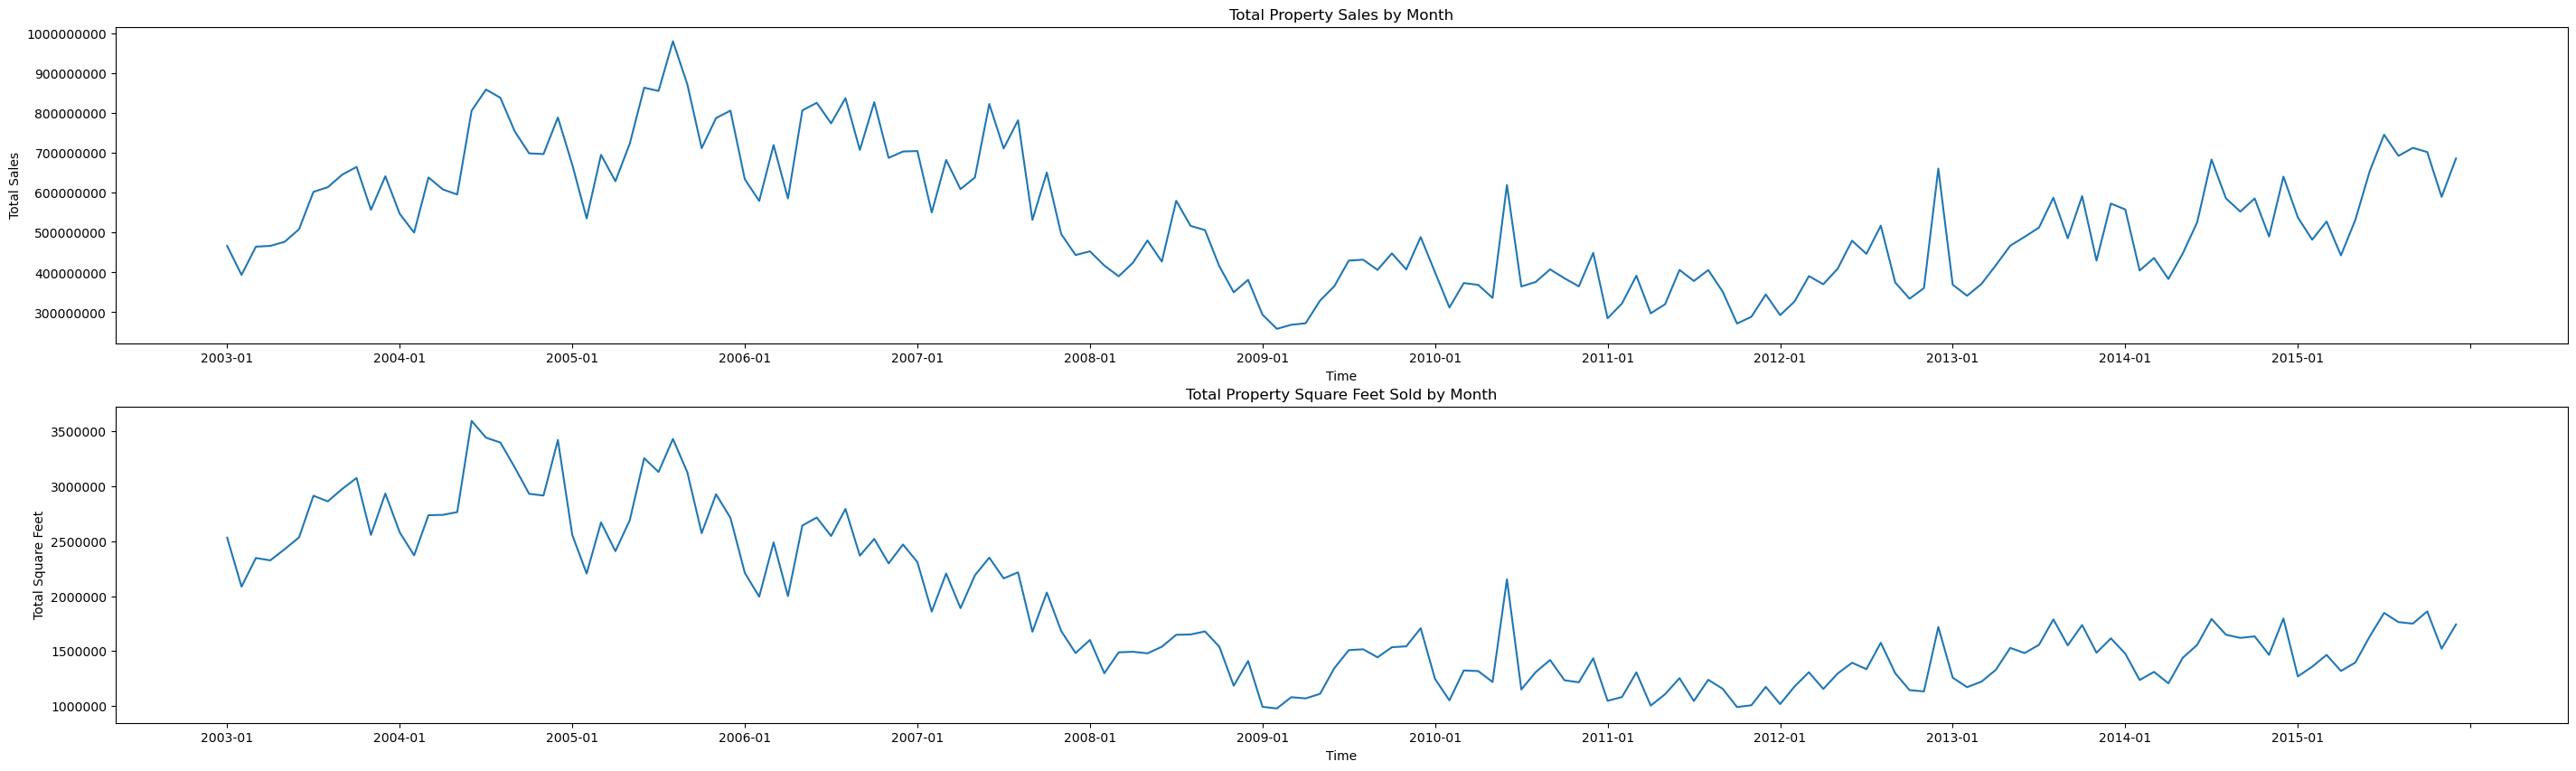

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 10))
plt.sca(ax1)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="total_sales", data=df_pandas)
plt.ylabel("Total Sales")
plt.xlabel("Time")
plt.title("Total Property Sales by Month")

plt.sca(ax2)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="square_feet", data=df_pandas)
plt.ylabel("Total Square Feet")
plt.xlabel("Time")
plt.title("Total Property Square Feet Sold by Month")
plt.show()

#### Summary of observations from the exploratory data analysis

- There is a clear recurring pattern on a yearly cadence which means that there is a **yearly seasonality**.
- It also seems that the summer months see higher sales volumes than the winter months.
- In years with high sales the difference between high sales months and low sales months is greater in absolute terms, than years with low sales. For instance, in 2004, the difference between the highest month and the lowest month is about $400,000,000 ($900,000,000 - $500,000,000), in comparison to 2011 where the difference is only $100,000,000 ($400,000,000 - $300,000,000). This becomes important later when we have to decide between **multiplicative** versus **additive** seasonality effects. 

## Step 4: Model Training and Tracking

### Model Fitting

We start by doing the model fitting.

The input to [Prophet](https://facebook.github.io/prophet/) is always a DataFrame with two columns; a time column `ds` and a value column `y`. The time column should be in temporal format (e.g. YYYY_MM) which is the case here, and the value column must be in numerical format.

To do the model fitting, we only need to rename the time column to `ds` and value column to `y` and pass the data to Prophet. For further information about this, you can refer to [Prophet's documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api).

In [ ]:
df_pandas["ds"] = pd.to_datetime(df_pandas["month"])
df_pandas["y"] = df_pandas["total_sales"]

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 21, Finished, Available)

Prophet follows the same convention as [sklearn](https://scikit-learn.org/). First we create a new instance of Prophet with some parameters (such as `seasonality_mode`), and then we fit that instance to the dataset.

- We use **'multiplicative' seasonality**, instead of a constant additive factor which is the default seasonality effect for Prophet. This came from our analysis in the previous section which showed that due to change in the amplitude of the seasonality, using a simple additive seasonality will not well fit the data.

- We turn **weekly_seasonality off**, as we have aggregated the data by month and we do not have weekly data.

- We use **Markov Chain Monte Carlo (MCMC)** in order to capture uncertainty estimates for seasonality. By default Prophet will be able to provide uncertainty estimates on the trend and observation noise, but not for the seasonality. Using MCMC takes longer, but does allow the algorithm to provide uncertainty estimates on the seasonality as well as the trend and observation noise. For more information, you can refer to [Prophet's documentation](https://facebook.github.io/prophet/docs/uncertainty_intervals.html).

- We try to tune the sensitivity of automatic change point detection through the **changepoint_prior_scale parameter**. The Prophet algorithm automatically tries to find instances in the data where the trajectories abruptly change. It is difficult to find the right value, therefore, we try different values and select the best performing model. You can refer to [Prophet's documentation](https://facebook.github.io/prophet/docs/trend_changepoints.html) to learn more about this parameter.

In [ ]:
from prophet import Prophet

def fit_model(dataframe, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples):
    m = Prophet(
        seasonality_mode=seasonality_mode,
        weekly_seasonality=weekly_seasonality,
        changepoint_prior_scale=chpt_prior,
        mcmc_samples=mcmc_samples,
    )
    m.fit(dataframe)
    return m

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 22, Finished, Available)

### Cross Validation

Prophet has a built-in cross-validation tool which can be useful to estimate the forecast error and find the best performing model.

Cross-validation is a technique for validating the model efficiency by training it on the subset of the dataset and testing on previously unseen subset of the dataset. We can also say that it is a technique to check how a statistical model generalizes to an independent dataset.

To do cross-validation, we reserve a particular sample of the dataset, which was not part of the training dataset and then we test the trained model on that sample prior to deployment. However, this approach does not work for time-series data, because if the model has seen January 2005, and March 2005, and we try to predict February 2005, the model can sort of "cheat" as it has been able to see where the data trend is going. In real applications, we are forecasting into the **_future_**, as the unseen regions. 

To tackle this challenge and make it a fair test, we split the dataset based on the dates. We use the dataset up to a certain date (i.e., the first 11 years of data) for training, and then use the remaining unseen data for prediction.

In this scenario, we start with 11 years of training data, and then make monthly predictions using a 1 year horizon. Specifically, our training data contains everything from 2003-2013. Then our first run is to predict January 2014 through January 2015. Then we predict February 2014 through February 2015, and so on. 

We repeat this for every one of our three models so we can compare which model performed the best and then we compare these predictions with the real world values to establish how good our best model is at predictions.

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

def evaluation(m):
    df_cv = cross_validation(m, initial="11 Y", period="30 days", horizon="365 days")
    df_p = performance_metrics(df_cv, monthly=True)
    future = m.make_future_dataframe(periods=12, freq="M")
    forecast = m.predict(future)
    return df_p, future, forecast

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 23, Finished, Available)

### Log Model with MLflow

We log the models to keep track of their parameters and save the models for later use. Note that all these information are logged under the experiment name in the workspace.

In [ ]:
# Setup Mlflow
from mlflow.models.signature import infer_signature

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 24, Finished, Available)

### Conduct Experiments

A machine learning experiment is the primary unit of organization and control for all related machine learning runs. A run corresponds to a single execution of model code. Machine learning experiment tracking refers to the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables to organize all the the required  components of a specific machine learning experiment as well as reproducing past results (easily) using saved experiments. You can learn more about machine learning experiments in Microsoft Fabric [here](https://aka.ms/synapse-experiment).
Finally, after determining the steps we intend to include, we can conduct the experiment. This involves fitting and evaluating the Prophet model. The model, parameters, and metrics, along with MLFlow autologging items, will be saved into one MLFlow run.

In [ ]:
model_name = f"{EXPERIMENT_NAME}-prophet"

models = []
df_metrics = []
forecasts = []
seasonality_mode = "multiplicative"
weekly_seasonality = False
changepoint_priors = [0.01, 0.05, 0.1]
mcmc_samples = 100

for chpt_prior in changepoint_priors:
    with mlflow.start_run(run_name=f"prophet_changepoint_{chpt_prior}"):
        # init model and fit
        m = fit_model(df_pandas, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples)
        models.append(m)
        # validation
        df_p, future, forecast = evaluation(m)
        df_metrics.append(df_p)
        forecasts.append(forecast)
        # log model and parameters with mlflow
        mlflow.prophet.log_model(
            m,
            model_name,
            registered_model_name=model_name,
            signature=infer_signature(future, forecast),
        )
        mlflow.log_params(
            {
                "seasonality_mode": seasonality_mode,
                "mcmc_samples": mcmc_samples,
                "weekly_seasonality": weekly_seasonality,
                "changepoint_prior": chpt_prior,
            }
        )
        metrics = df_p.mean().to_dict()
        metrics.pop("horizon")
        mlflow.log_metrics(metrics)

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/Timeseries-experiment.png"  width="70%" height="30%">

### Model Visualization with Prophet

Prophet has built-in visualization functions which can be used to show the model fitting results. 

The black dots denote the data points that are used to train the model. The blue line is the prediction, and the light blue area shows the uncertainty intervals. Note that we have built three models with varying levels of `changepoint_prior_scale`. The predictions of these three models are shown below.

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 26, Finished, Available)

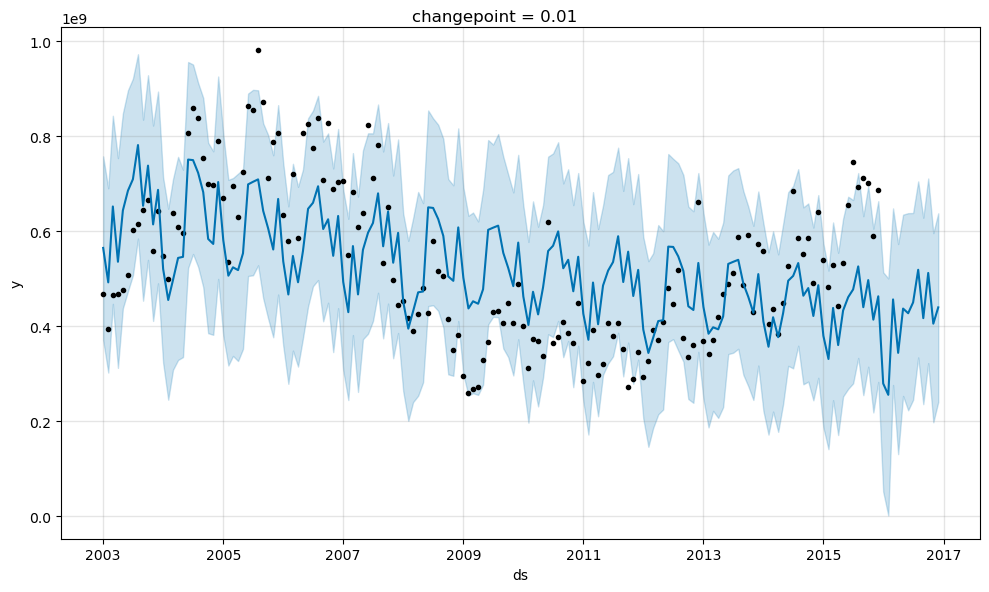

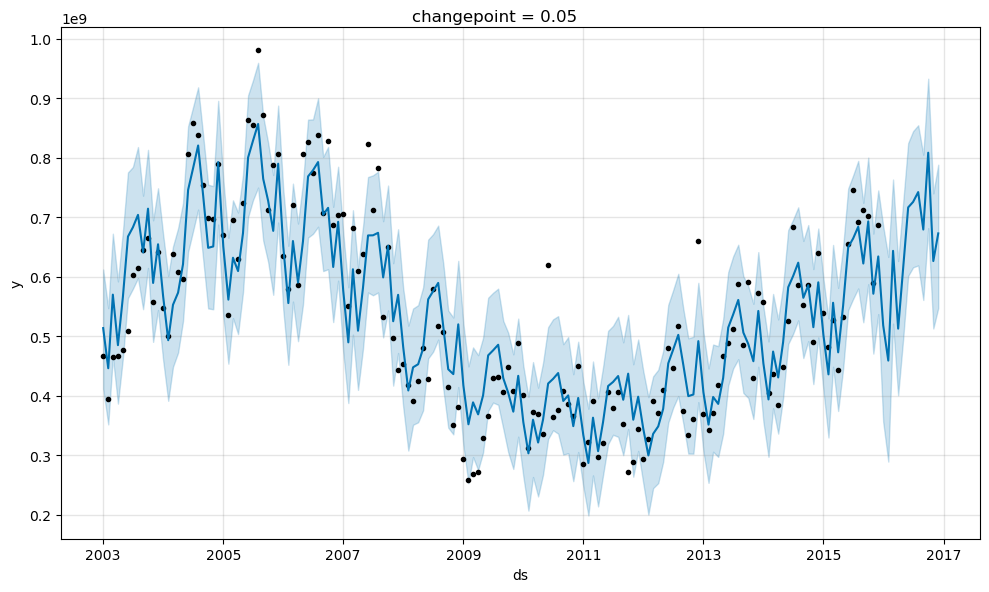

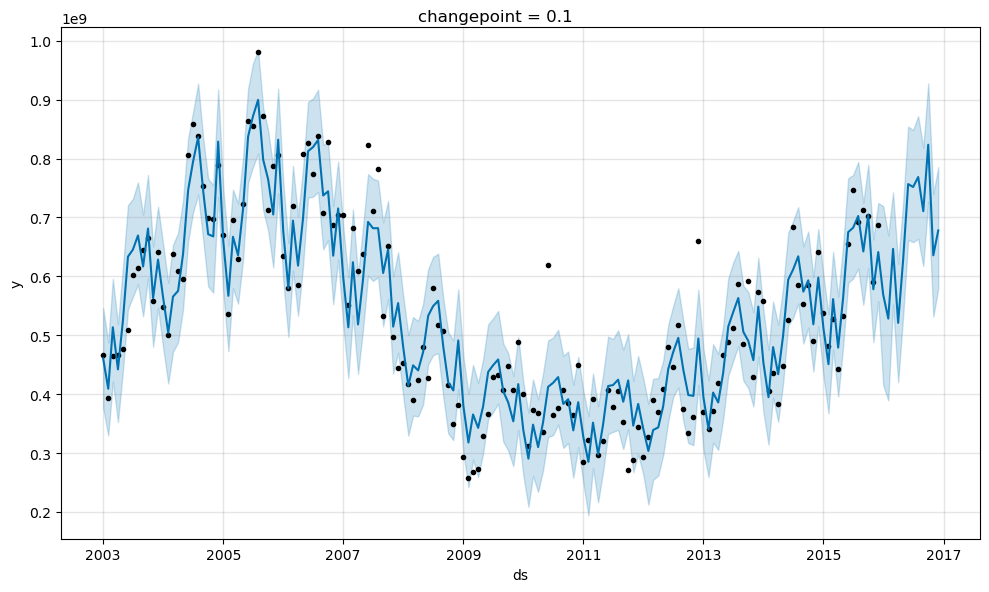

In [ ]:
for idx, pack in enumerate(zip(models, forecasts)):
    m, forecast = pack
    fig = m.plot(forecast)
    fig.suptitle(f"changepoint = {changepoint_priors[idx]}")

Upon observing the plot, it has become clear that the smallest `changepoint_prior_scale` (first plot) leads to underfitting of trend changes, whereas the largest `changepoint_prior_scale` (third plot) may result in overfitting. Consequently, the second plot appears to be the optimal choice, implying that the second model is the most suitable.

### Visualize trend and seasonality with Prophet

Another useful feature of Prophet is the capability to easily visualize the underlying trends and seasonalities. Visualizations of the second model are shown below.

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 27, Finished, Available)

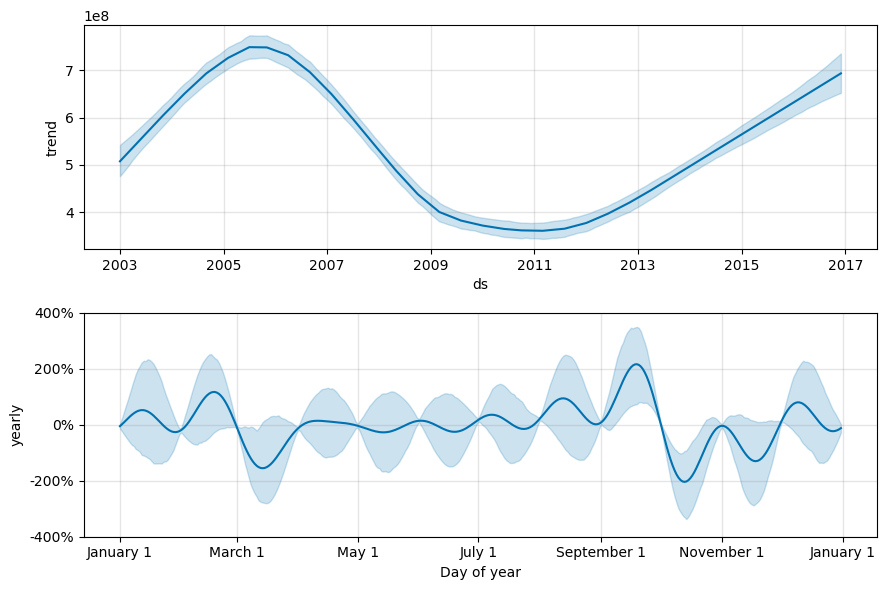

In [ ]:
BEST_MODEL_INDEX = 1  # set best model index according to the previous results
fig2 = models[BEST_MODEL_INDEX].plot_components(forecast)

The light blue area reflects the uncertainty and we can see from the top plot that there seems to be a strong long-period oscillating trend, e.g., over the course of a few years the sales volumes rises and falls. On the other hand, the bottom plot demonstrates that the sales tend to peak in February and September, reaching their maximum values for the year, but shortly after in March and October, they plunge to the year's minimum values.

We can evaluate the performance of the models using various metrics, i.e., mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE), symmetric mean absolute percentage error (SMAPE) and coverage of the `yhat_lower` and `yhat_upper` estimates. Also, note the varying horizons where we predict one year in the future 12 times.

In [ ]:
display(df_metrics[BEST_MODEL_INDEX])

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 28, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 024d9a7f-af5a-4821-af86-dc1c4175b384)

Using the MAPE metric, we realize that for this forecasting model, the errors of around 8% are typical for predictions that are one month into the future. However, for predictions that are a year out the error increases to around 10% .

## Step 5: Deploy model and save prediction results

Finally, we will deploy the model and save the prediction results.




#### Prediction with Predict Transformer

We can now load the model and use it to make predictions. Microsoft Fabric allows users to operationalize machine learning models with a scalable function called PREDICT, which supports batch scoring in any compute engine. You can learn more about ```PREDICT``` and how to use it within Microsoft Fabric [here](https://aka.ms/fabric-predict).

In [ ]:
from synapse.ml.predict import MLFlowTransformer

spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=future.columns.values,
    outputCol="prediction",
    modelName=f"{EXPERIMENT_NAME}-prophet",
    modelVersion=BEST_MODEL_INDEX,
)

test_spark = spark.createDataFrame(data=future, schema=future.columns.to_list())

batch_predictions = model.transform(test_spark)

display(batch_predictions)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 29, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


SynapseWidget(Synapse.DataFrame, c8d9d97b-2627-42dc-b1ea-44b567806f64)

In [ ]:
# Code for saving predictions into lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 30, Finished, Available)

In [ ]:
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 31, Finished, Available)

Full run cost 150 seconds.
